# Pharmacokinetic model class
The PKModel abstract base class represents pharmacokinetic models, i.e. models to predict tissue CA concentration. Subclasses represent specific models, e.g. Patlak.
The main function of the class is to provide a conc method, which returns the CA concentration for the capillary plasma and EES spaces, and the whole tissue.

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sepal import aifs, pk_models
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Example
Create a PKModel object and use to predict CA concentration.  
To do this we need to specify:
- The time points at which we need to calculate concentration
- An AIF object:

In [16]:
dt = 2
t = np.arange(0,100)*dt + dt/2  # t = 1, 3, ..., 199 s
aif = aifs.Parker(hct=0.42, t_start=15)

pkm_tcxm = pk_models.TCXM(t, aif)

The names and order of the parameters can be obtained from the object:

In [17]:
pkm_tcxm.parameter_names

('vp', 'ps', 've', 'fp')

Calculate concentration using the conc method (parameters can be passed as positional or keyword arguments):

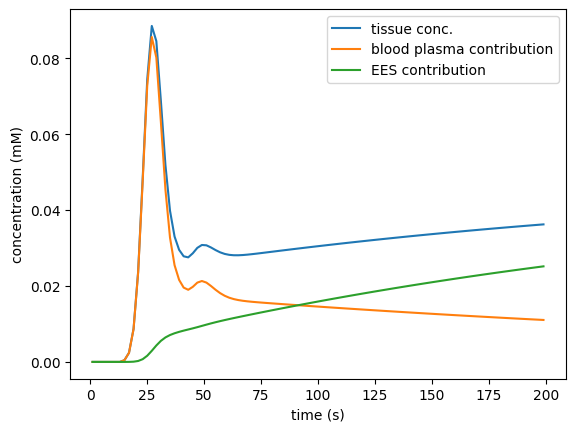

In [18]:
pkp = {'vp': 0.01, 'ps': 5e-3, 've': 0.2, 'fp': 20}
C_t, C_cp, C_e = pkm_tcxm.conc(**pkp)

plt.plot(t, C_t, '-', label='tissue conc.')
plt.plot(t, C_cp, '-', label='blood plasma contribution')
plt.plot(t, C_e, '-', label='EES contribution')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('concentration (mM)');

Parameters can be converted between dict (for readability) and array (for optimisation algorithms) formats:

In [19]:
pkp_array = pkm_tcxm.pkp_array(pkp)
pkp_dict = pkm_tcxm.pkp_dict(pkp_array)
print(f"Parameters as array: {pkp_array}")
print(f"Parameters as dict: {pkp_dict}")

Parameters as array: [1.e-02 5.e-03 2.e-01 2.e+01]
Parameters as dict: {'vp': 0.01, 'ps': 0.005, 've': 0.2, 'fp': 20.0}


Required parameters have typical values (for scaling and as default initial estimates) and bounds (for fitting):

In [20]:
print(f"Parameter names for this model are: {pkm_tcxm.parameter_names}")
print(f"Typical values for these parameters are: {pkm_tcxm.typical_vals}")
print(f"Bounds for these parameters are: {pkm_tcxm.bounds}")

Parameter names for this model are: ('vp', 'ps', 've', 'fp')
Typical values for these parameters are: [ 0.1   0.05  0.5  50.  ]
Bounds for these parameters are: ((1e-08, -0.001, 1e-08, 1e-08), (1, 1, 1, 200))


We can also specify a fixed artery-capillary delay for the model:

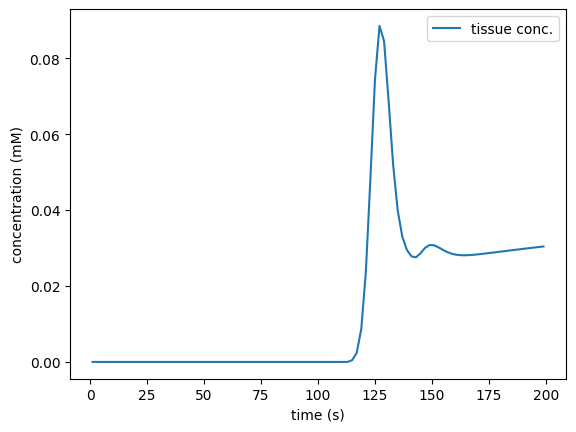

In [21]:
C_t_delayed, _, _ = pk_models.TCXM(t, aif, fixed_delay=100).conc(**pkp)

plt.plot(t, C_t_delayed, '-', label='tissue conc.')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('concentration (mM)');

The default delay is zero. If set to None, the delay is assumed to be a fitted parameter and must be specified with the other parameters when calling the conc method:

In [22]:
pkm_tcxm_var_delay = pk_models.TCXM(t, aif, fixed_delay=None)
pkm_tcxm_var_delay.parameter_names

('vp', 'ps', 've', 'fp', 'delay')

The irf method returns the impulse response functions for the plasma and EES compartments:

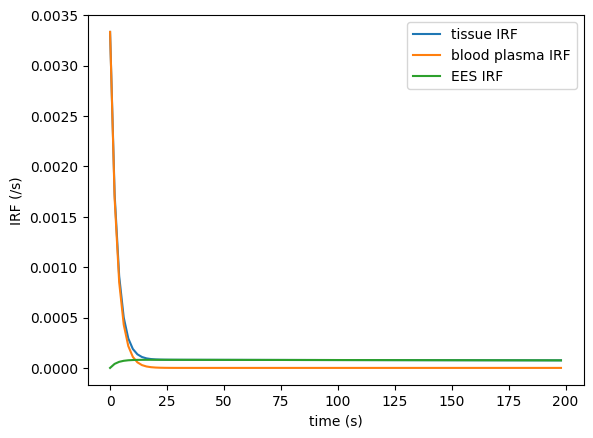

In [23]:
irf_cp, irf_ees = pkm_tcxm.irf(**pkp)
irf_tissue = irf_cp + irf_ees

plt.plot(pkm_tcxm.tau_upsample, irf_tissue, '-', label='tissue IRF')
plt.plot(pkm_tcxm.tau_upsample, irf_cp, '-', label='blood plasma IRF')
plt.plot(pkm_tcxm.tau_upsample, irf_ees, '-', label='EES IRF')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('IRF (/s)');

#### Interpolation
Concentration is calculated by discrete convolution of the AIF and IRF at the required time points. If either function is temporally undersampled then the calculated concentration may not be accurate. In our example, if we set a high Fp then the IRF will not be properly sampled:

In [24]:
C_t_default, _, _ = pk_models.TCXM(t, aif).conc(vp=0.01, ps=5e-3, ve=0.2, fp=200)

We can correct this by upsampling the AIF and IRF for the convolution step (concentration is still calculated at the requested time points). To do this, use the upsample_factor parameter when creating the PKModel object:

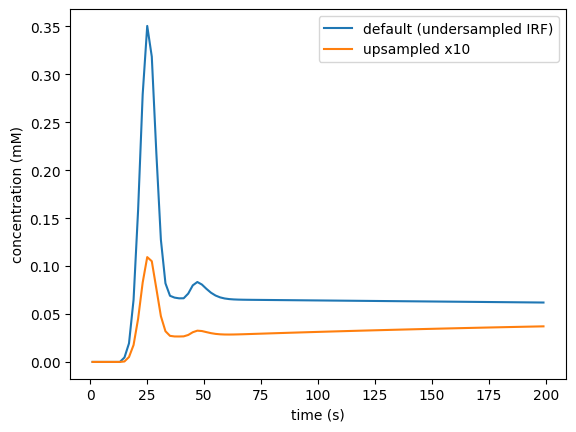

In [25]:
C_t_upsampled, _, _ = pk_models.TCXM(t, aif, upsample_factor=10).conc(vp=0.01, ps=5e-3, ve=0.2, fp=200)

plt.plot(t, C_t_default, '-', label='default (undersampled IRF)')
plt.plot(t, C_t_upsampled, '-', label='upsampled x10')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('concentration (mM)');

Of course, if the AIF is based on Patient data that is temporally undersampled then upsampling won't correct for this. In our example, the AIF is a continuous (Parker) function, so upsampling of the AIF should further increase the accuracy.

#### Compare models

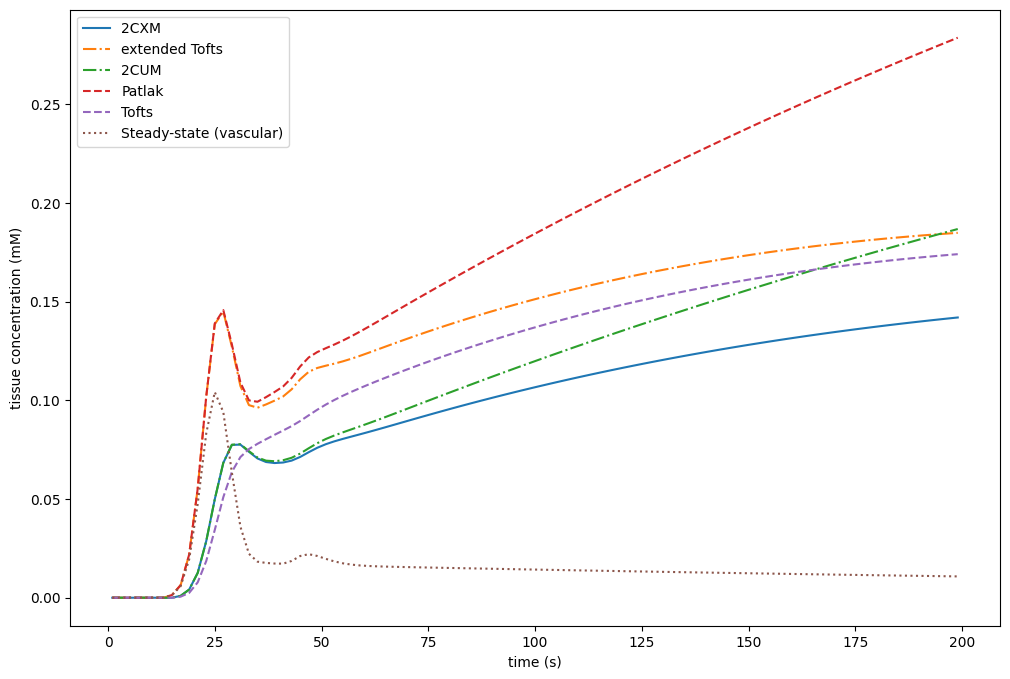

In [26]:
pkm_tcxm = pk_models.TCXM(t, aif, upsample_factor=10)
pkm_etofts = pk_models.ExtendedTofts(t, aif, upsample_factor=10)
pkm_tcum = pk_models.TCUM(t, aif, upsample_factor=10)
pkm_patlak = pk_models.Patlak(t, aif, upsample_factor=10)
pkm_tofts = pk_models.Tofts(t, aif, upsample_factor=10)
pkm_steady_state = pk_models.SteadyStateVp(t, aif, upsample_factor=10)

pk_pars = {'vp': 0.01, 'ps': 5e-2, 've': 0.2, 'fp': 10, 'ktrans': 5e-2}
# N.B. unnecessary parameters are ignored.

C_t_tcxm, _, _ = pkm_tcxm.conc(**pk_pars)
C_t_etofts, _, _ = pkm_etofts.conc(**pk_pars)
C_t_tcum, _, _ = pkm_tcum.conc(**pk_pars)
C_t_patlak, _, _ = pkm_patlak.conc(**pk_pars)
C_t_tofts, _, _ = pkm_tofts.conc(**pk_pars)
C_t_steady_state, _, _ = pkm_steady_state.conc(**pk_pars)

plt.figure(0, figsize=(12,8))
plt.plot(t, C_t_tcxm, '-', label='2CXM')
plt.plot(t, C_t_etofts, '-.', label='extended Tofts')
plt.plot(t, C_t_tcum, '-.', label='2CUM')
plt.plot(t, C_t_patlak, '--', label='Patlak')
plt.plot(t, C_t_tofts, '--', label='Tofts')
plt.plot(t, C_t_steady_state, ':', label='Steady-state (vascular)')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('tissue concentration (mM)');